<a href="https://colab.research.google.com/github/arsalanbakhtiarab/MyAgenticJourney/blob/main/Agentic_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Agentic AI with LangGraph - Complete Tutorial

**By the end of this notebook, you will be able to:**
* Understand how LangGraph supports agentic workflows
* Implement agents with memory and multi-step planning  
* Build, visualize, and run LangGraphs with tools
* Grasp core principles of designing autonomous agents
* Create ReAct architecture for iterative reasoning

---

## 🔧 Step 1: Setup and Installation

### Install Required Packages

To build and run LangGraph-based agents, we need several key libraries:

* `langchain_google_genai`, `langchain_core`, `langchain_community`: Modules that provide the LLM interface and tools
* `tavily-python`: For web search integration  
* `pydantic`: For data validation and structured outputs
* `langgraph`: Core library to construct stateful, agentic workflows

In [20]:
# Install all required packages
%pip install --quiet -U langchain_google_genai langchain_core langchain_community
%pip install --quiet -U tavily-python pydantic langgraph

### 📦 Import Essential Libraries

In [19]:
import os
import random
from typing import Literal
from pprint import pprint

from pydantic import BaseModel
from IPython.display import Image, display

# LangGraph imports
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# LangChain imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

### 🔑 Authentication Setup
We retrieve the API key for Google Generative AI and initialize the model:

In [22]:
# For Google Colab users
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

# For local environment users (uncomment if needed)
# import getpass
# GEMINI_API_KEY = getpass.getpass("Enter your Gemini API key: ")

# Initialize the language model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GEMINI_API_KEY,
    temperature=0
)

# Test the model connection
print("Testing LLM connection...")
response = llm.invoke("Hello! Can you confirm you're working?")
print(f"Response: {response.content}")

Testing LLM connection...
Response: Yes, I am working. How can I help you?


## 🧾 Step 2: Define State and Basic Graph Construction

### Define the State Schema

The State schema serves as the input schema for all Nodes and Edges in the graph:

* Each node returns a new value of the state key `graph_state`
* By default, the new value returned by each node will override the prior state value
* State must be a Pydantic model for type safety

In [23]:
class LearningState(BaseModel):
    prompt: str

# Create an example instance of learning_state
state = LearningState(prompt="Hello from LangGraph")
print(f"State: {state}")
print(f"Prompt: {state.prompt}")
print(f"State type: {type(state)}")

State: prompt='Hello from LangGraph'
Prompt: Hello from LangGraph
State type: <class '__main__.LearningState'>


 🔄 Define Nodes

Nodes are just Python functions with these characteristics:

* The first positional argument is the state (a Pydantic model)
* Since the state is a Pydantic model, nodes can access fields like: `state.prompt`
* Each node returns a new instance of the state with an updated value
* By default, this new value replaces the old one

In [24]:
def node_1(state: LearningState) -> LearningState:
    print("--- Executing Node 1 ---")
    return LearningState(prompt=state.prompt + " I am")

def node_2(state: LearningState) -> LearningState:
    print("--- Executing Node 2 ---")
    return LearningState(prompt=state.prompt + " learning")


### 🔗 Build Linear Graph

Edges connect the nodes with these rules:

* Normal Edges are used if you want to always go from one node to another
* We use the `START` Node, a special node that sends user input to the graph
* The `END` Node is a special node that represents a terminal node
* Finally, we compile our graph to perform basic checks on the graph structure

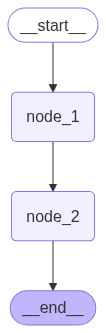

--- Executing Node 1 ---
--- Executing Node 2 ---
Final result: {'prompt': 'Hi I am learning'}


In [25]:
# Build linear graph
builder = StateGraph(state_schema=LearningState)

# Add nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Add simple edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Compile and visualize
linear_graph = builder.compile()
display(Image(linear_graph.get_graph().draw_mermaid_png()))

# Execute the graph
result = linear_graph.invoke({"prompt": "Hi"})
print(f"Final result: {result}")

## 🔁 Step 3: Conditional Edges and Routing

### Understanding Conditional Edges

Conditional Edges are used when you want to optionally route between nodes:

* Conditional edges are implemented as functions that return the next node to visit
* The routing decision is based on the current state
* This enables dynamic workflow control based on data or conditions

In [26]:
def node_happy(state: LearningState) -> LearningState:
    print("--- Happy Path ---")
    return LearningState(prompt=state.prompt + " happy")

def node_sad(state: LearningState) -> LearningState:
    print("--- Sad Path ---")
    return LearningState(prompt=state.prompt + " sad")

def decide_mood(state: LearningState) -> Literal["node_happy", "node_sad"]:
    """
    Routing function that decides which path to take:
    * Often, we will use state to decide on the next node to visit
    * Here, we do a 50/50 split between happy and sad paths
    * Returns the name of the next node to execute
    """
    user_input = state.prompt

    if random.random() < 0.5:
        return "node_happy"  # 50% of the time, go to happy node
    else:
        return "node_sad"    # 50% of the time, go to sad node

### Build Conditional Graph

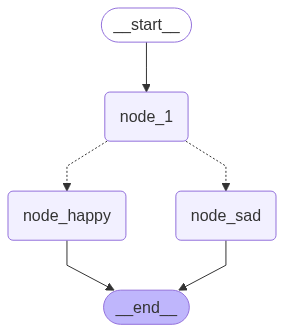

=== Testing Conditional Routing ===
--- Executing Node 1 ---
--- Happy Path ---
Execution 1: Test 1 I am happy
--- Executing Node 1 ---
--- Happy Path ---
Execution 2: Test 2 I am happy
--- Executing Node 1 ---
--- Sad Path ---
Execution 3: Test 3 I am sad


In [27]:
# Build conditional routing graph
builder = StateGraph(LearningState)

# Add all nodes
builder.add_node("node_1", node_1)
builder.add_node("node_happy", node_happy)
builder.add_node("node_sad", node_sad)

# Add routing logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_happy", END)
builder.add_edge("node_sad", END)

conditional_graph = builder.compile()
display(Image(conditional_graph.get_graph().draw_mermaid_png()))

# Test multiple executions to see different paths
print("=== Testing Conditional Routing ===")
for i in range(3):
    result = conditional_graph.invoke({"prompt": f"Test {i+1}"})
    print(f"Execution {i+1}: {result['prompt']}")

## 💬 Step 4: Working with Messages

### Understanding Message Types

Chat models can use messages, which capture different roles within a conversation:

* `HumanMessage`: Represents a message from the user
* `AIMessage`: Represents a message from the chat model  
* `SystemMessage`: Instructions for the chat model to guide behavior
* `ToolMessage`: Represents output from a tool call

Each message can be supplied with:
* `content`: Content of the message
* `name`: Optionally, a message author
* `response_metadata`: Optionally, a dict of metadata"

In [30]:
# Create a conversation with different message types
messages = [
    AIMessage(content="So you said you were researching ocean mammals?", name="Model"),
    HumanMessage(content="Yes, that's right.", name="Arsalan"),
    AIMessage(content="Great, what would you like to learn about?", name="Model"),
    HumanMessage(content="I want to learn about the best place to see Orcas in the US.", name="Arsalan")
]

print("=== Message Conversation ===")
for message in messages:
    message.pretty_print()

=== Message Conversation ===
================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Arsalan

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about?
================================ Human Message =================================
Name: Arsalan

I want to learn about the best place to see Orcas in the US.


## 🛠️ Step 5: Tools and Function Calling

### Understanding Tools

Tools are useful whenever you want a model to interact with external systems:

* External systems (APIs) often require a particular input schema, not natural language
* When we bind an API as a tool, we give the model awareness of the required input schema
* The model will choose to call a tool based upon natural language input from the user
* It returns an output that adheres to the tool's schema
* Many LLM providers support tool calling through LangChain's simple interface

### Define Mathematical Tools

In [32]:
def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer

    Returns:
        Sum of a and b
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide two numbers.

    Args:
        a: Dividend
        b: Divisor

    Returns:
        Result of a divided by b
    """
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

# Bind tools to the model
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

### 🔁 Router: Tool Call vs Direct Response

We can think of this as a **router**, where the **chat model decides** whether to:

* Directly **respond to the user**, or  
* **Invoke a tool** based on the user input

This is a **simple example of an agent**, where the LLM directs the **control flow**.

Key LangGraph concepts for tool integration:
* `ToolNode`: A node that performs tool execution
* `tools_condition`: A conditional edge that checks if a tool was requested

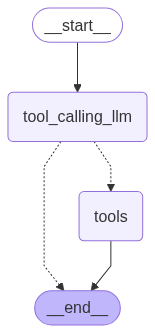

In [33]:
def tool_calling_llm(state: MessagesState) -> MessagesState:
    """Node that invokes the LLM with tool capabilities"""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build tool router graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add routing logic
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

tool_router = builder.compile()
display(Image(tool_router.get_graph().draw_mermaid_png()))

### Test Tool Usage


In [34]:
print("=== Tool Router Examples ===")

# Example 1: Math calculation
messages = [HumanMessage(content="What is 6 multiplied by 7?")]
result = tool_router.invoke({"messages": messages})

print("--- Math Calculation ---")
for message in result['messages']:
    message.pretty_print()

print("\n--- Addition Example ---")
messages = [HumanMessage(content="Add 15 and 28")]
result = tool_router.invoke({"messages": messages})

for message in result['messages']:
    message.pretty_print()

=== Tool Router Examples ===
--- Math Calculation ---
================================ Human Message =================================

What is 6 multiplied by 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (0013b444-6a90-4940-b01f-6d2b45a7e6cb)
 Call ID: 0013b444-6a90-4940-b01f-6d2b45a7e6cb
  Args:
    a: 6.0
    b: 7.0
================================= Tool Message =================================
Name: multiply

42

--- Addition Example ---
================================ Human Message =================================

Add 15 and 28
================================== Ai Message ==================================
Tool Calls:
  add (8a24ecc7-4776-4c0b-a946-3d59c2e9dece)
 Call ID: 8a24ecc7-4776-4c0b-a946-3d59c2e9dece
  Args:
    a: 15.0
    b: 28.0
================================= Tool Message =================================
Name: add

43


## 🤖 Step 6: ReAct Agent with Iterative Tool Use

### 🔍 Understanding ReAct Architecture

We extend the router to a **generic agent architecture**:

* Instead of ending after a tool call, **pass the ToolMessage back to the model**
* The model can then:
  1. **Call another tool** (act)
  2. **Respond directly** (respond)

This cycle models the **ReAct architecture**:
* **Act**: Model calls a tool
* **Observe**: Pass tool output back to model  
* **Reason**: Model reasons about tool output and decides next step

This loop allows more complex, chained reasoning and tool usage.

### 🎯 Goals of ReAct Agent

The ReAct agent enables:
* **Multi-step problem solving**: Break complex problems into steps
* **Tool chaining**: Use output of one tool as input to another
* **Iterative reasoning**: Continuously evaluate and adjust approach
* **Flexible decision making**: Choose when to use tools vs respond directly

### Build ReAct Agent

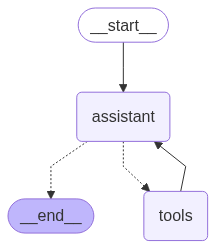

In [36]:
# System prompt for agent behavior
sys_msg = SystemMessage(content="""You are a helpful assistant tasked with performing arithmetic operations.
Work step by step and use the available tools to solve complex problems.
Show your reasoning process clearly.""")

def assistant(state: MessagesState) -> MessagesState:
    """Assistant node that processes messages with tool capabilities"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build ReAct agent graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Create the ReAct loop
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")  # This creates the iterative loop

react_agent = builder.compile()
display(Image(react_agent.get_graph(xray=True).draw_mermaid_png()))

### Test Multi-Step Reasoning

In [37]:
print("=== Multi-Step Arithmetic Test ===")

# Complex calculation requiring multiple steps
messages = [HumanMessage(content="Add 3 and 4, then multiply the result by 2, then divide by 5.")]
result = react_agent.invoke({"messages": messages})

print("ReAct Agent Execution:")
for message in result['messages']:
    message.pretty_print()
    print("---")

print("\n=== Another Complex Example ===")
messages = [HumanMessage(content="Calculate (15 + 25) * 3, then divide the result by 6")]
result = react_agent.invoke({"messages": messages})

for message in result['messages']:
    message.pretty_print()
    print("---")

=== Multi-Step Arithmetic Test ===
ReAct Agent Execution:
================================ Human Message =================================

Add 3 and 4, then multiply the result by 2, then divide by 5.
---
================================== Ai Message ==================================
Tool Calls:
  add (0af204f8-07c9-429e-bad7-1b32d91ef7a8)
 Call ID: 0af204f8-07c9-429e-bad7-1b32d91ef7a8
  Args:
    a: 3.0
    b: 4.0
---
================================= Tool Message =================================
Name: add

7
---
================================== Ai Message ==================================
Tool Calls:
  multiply (7ad988e5-9f52-4263-a06a-1bfc5c08496a)
 Call ID: 7ad988e5-9f52-4263-a06a-1bfc5c08496a
  Args:
    a: 7.0
    b: 2.0
---
================================= Tool Message =================================
Name: multiply

14
---
================================== Ai Message ==================================
Tool Calls:
  divide (8c771583-a381-4c93-9956-817c35007a95)
 Call ID

## 💾 Step 7: Agent Memory - Persistent Conversations

### Understanding Memory Limitations

When running multiple turns **without persistence**, the state is **transient**:

* The model forgets past results between conversations
* Example:
  * User: "Add 3 and 4." → Agent responds "7"
  * User: "Multiply that by 2." → Agent asks "Please provide the number..." because it forgot

### Introducing Persistent Memory

**MemorySaver** provides persistent memory capabilities:

* **MemorySaver**: An in-memory key-value store for graph state
* **Checkpoint system**: Automatically saves the graph state after each step
* **Thread-based conversations**: Use `thread_id` to maintain separate conversation contexts
* **State persistence**: Enables the agent to retain conversation context across multiple invocations

This shifts the agent from **transient state** to a **steady state**.

### Create Memory-Enabled Agent

In [38]:
# Create memory checkpointer
memory = MemorySaver()
react_agent_with_memory = builder.compile(checkpointer=memory)

# Configuration for persistent conversation thread
config = {"configurable": {"thread_id": "conversation_1"}}

print("=== Testing Persistent Memory ===")

# First interaction
print("\n--- First Turn ---")
result1 = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="Calculate 15 + 25")]},
    config
)
for message in result1['messages']:
    message.pretty_print()

# Second interaction - should remember previous context
print("\n--- Second Turn ---")
result2 = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="Now multiply that result by 3")]},
    config
)
for message in result2['messages']:
    message.pretty_print()

# Third interaction - testing memory retention
print("\n--- Third Turn ---")
result3 = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="What was the original sum before multiplication?")]},
    config
)
for message in result3['messages']:
    message.pretty_print()

=== Testing Persistent Memory ===

--- First Turn ---
================================ Human Message =================================

Calculate 15 + 25
================================== Ai Message ==================================
Tool Calls:
  add (b608ce6e-b4c2-45eb-ab79-ba1d70d5a931)
 Call ID: b608ce6e-b4c2-45eb-ab79-ba1d70d5a931
  Args:
    a: 15.0
    b: 25.0
================================= Tool Message =================================
Name: add

40
================================== Ai Message ==================================

15 + 25 = 40

--- Second Turn ---
================================ Human Message =================================

Calculate 15 + 25
================================== Ai Message ==================================
Tool Calls:
  add (b608ce6e-b4c2-45eb-ab79-ba1d70d5a931)
 Call ID: b608ce6e-b4c2-45eb-ab79-ba1d70d5a931
  Args:
    a: 15.0
    b: 25.0
================================= Tool Message =================================
Name: add

40
======

### Demonstrate Different Conversation Threads

In [39]:
print("=== Different Conversation Threads ===")

# Create a new thread - should not remember previous conversation
config_new = {"configurable": {"thread_id": "conversation_2"}}

print("\n--- New Thread (should not remember previous conversation) ---")
result_new = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="What was the last calculation we did?")]},
    config_new
)
for message in result_new['messages']:
    message.pretty_print()

print("\n--- Back to Original Thread ---")
# Switch back to original thread - should remember the context
result_original = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="Can you remind me what we calculated?")]},
    config  # Using original thread_id
)
for message in result_original['messages']:
    message.pretty_print()

=== Different Conversation Threads ===

--- New Thread (should not remember previous conversation) ---
================================ Human Message =================================

What was the last calculation we did?
================================== Ai Message ==================================

I am a new assistant, and I don't have memory of past conversations. So I don't know what the last calculation was.

--- Back to Original Thread ---
================================ Human Message =================================

Calculate 15 + 25
================================== Ai Message ==================================
Tool Calls:
  add (b608ce6e-b4c2-45eb-ab79-ba1d70d5a931)
 Call ID: b608ce6e-b4c2-45eb-ab79-ba1d70d5a931
  Args:
    a: 15.0
    b: 25.0
================================= Tool Message =================================
Name: add

40
================================== Ai Message ==================================

15 + 25 = 40
================================ Human 

## 🧪 Step 8: Advanced Examples and Use Cases

### Complex Problem Solving

In [40]:
print("=== Complex Problem Solving ===")

complex_problem = """
I have a rectangular garden that is 12 meters long and 8 meters wide.
Please help me with these calculations:
1. Calculate the area of the garden
2. If I want to put a fence around it, calculate the perimeter
3. If fencing costs $15 per meter, what's the total cost?
"""

result = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content=complex_problem)]},
    {"configurable": {"thread_id": "garden_problem"}}
)

for message in result['messages']:
    message.pretty_print()

=== Complex Problem Solving ===
================================ Human Message =================================


I have a rectangular garden that is 12 meters long and 8 meters wide.
Please help me with these calculations:
1. Calculate the area of the garden
2. If I want to put a fence around it, calculate the perimeter  
3. If fencing costs $15 per meter, what's the total cost?

================================== Ai Message ==================================

Okay, let's break this down step by step.

1.  **Area of the garden:** The area of a rectangle is calculated by multiplying its length and width. So, the area is 12 meters * 8 meters.
2.  **Perimeter of the garden:** The perimeter of a rectangle is calculated by adding up all the sides. That's length + width + length + width, or 2 * (length + width). So, the perimeter is 2 * (12 meters + 8 meters).
3.  **Total cost of fencing:**  Multiply the perimeter by the cost per meter, which is $15.

Now, let's use the available tools to 

### Error Handling and Edge Cases

In [41]:
print("=== Error Handling Test ===")

# Test division by zero
print("\n--- Division by Zero Test ---")
error_test = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="What is 10 divided by 0?")]},
    {"configurable": {"thread_id": "error_test"}}
)

for message in error_test['messages']:
    message.pretty_print()

# Test with very large numbers
print("\n--- Large Number Test ---")
large_test = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="Multiply 999999 by 888888")]},
    {"configurable": {"thread_id": "large_numbers"}}
)

for message in large_test['messages']:
    message.pretty_print()

=== Error Handling Test ===

--- Division by Zero Test ---
================================ Human Message =================================

What is 10 divided by 0?
================================== Ai Message ==================================
Tool Calls:
  divide (60929135-10ff-4827-bb19-ad0c2abcdae8)
 Call ID: 60929135-10ff-4827-bb19-ad0c2abcdae8
  Args:
    a: 10.0
    b: 0.0
================================= Tool Message =================================
Name: divide

Error: ValueError('Cannot divide by zero')
 Please fix your mistakes.
================================== Ai Message ==================================

I cannot divide by zero. It is not mathematically possible.

--- Large Number Test ---
================================ Human Message =================================

Multiply 999999 by 888888
================================== Ai Message ==================================
Tool Calls:
  multiply (5a2d61ee-c47d-4aaf-b96c-ce84e5871b05)
 Call ID: 5a2d61ee-c47d-4aaf-b

### Multi-Turn Mathematical Conversation

In [42]:
print("=== Multi-Turn Mathematical Conversation ===")

# Start a mathematical conversation thread
math_config = {"configurable": {"thread_id": "math_conversation"}}

# Turn 1: Start with basic calculation
print("\n--- Turn 1 ---")
turn1 = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="Let's start with 5 + 3")]},
    math_config
)
for message in turn1['messages']:
    message.pretty_print()

# Turn 2: Build on previous result
print("\n--- Turn 2 ---")
turn2 = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="Square that result")]},
    math_config
)
for message in turn2['messages']:
    message.pretty_print()

# Turn 3: Continue the sequence
print("\n--- Turn 3 ---")
turn3 = react_agent_with_memory.invoke(
    {"messages": [HumanMessage(content="Divide by 4 and then add 10")]},
    math_config
)
for message in turn3['messages']:
    message.pretty_print()

=== Multi-Turn Mathematical Conversation ===

--- Turn 1 ---
================================ Human Message =================================

Let's start with 5 + 3
================================== Ai Message ==================================
Tool Calls:
  add (e46fbcd2-ddd7-4011-871d-892484326feb)
 Call ID: e46fbcd2-ddd7-4011-871d-892484326feb
  Args:
    a: 5.0
    b: 3.0
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

The answer is 8.

--- Turn 2 ---
================================ Human Message =================================

Let's start with 5 + 3
================================== Ai Message ==================================
Tool Calls:
  add (e46fbcd2-ddd7-4011-871d-892484326feb)
 Call ID: e46fbcd2-ddd7-4011-871d-892484326feb
  Args:
    a: 5.0
    b: 3.0
================================= Tool Message =================================
Name: add

## 📈 Step 9: Graph Analysis and Debugging

### Visualize Graph Structure

Understanding your graph structure is crucial for debugging and optimization:

* **Nodes**: The processing units of your graph
* **Edges**: The connections and flow control
* **State flow**: How data moves through the graph
* **Conditional logic**: Where decisions are made

=== Graph Structure Analysis ===
Nodes: ['__start__', 'assistant', 'tools', '__end__']
Edges: 4 connections

--- Normal View ---


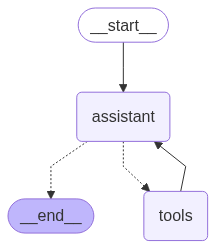


--- X-Ray View (shows internal structure) ---


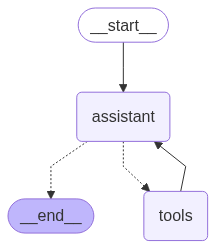

In [43]:
print("=== Graph Structure Analysis ===")

# Show detailed graph structure
graph_dict = react_agent_with_memory.get_graph()
print(f"Nodes: {list(graph_dict.nodes.keys())}")
print(f"Edges: {len(graph_dict.edges)} connections")

# Display both normal and X-ray views
print("\n--- Normal View ---")
display(Image(react_agent_with_memory.get_graph().draw_mermaid_png()))

print("\n--- X-Ray View (shows internal structure) ---")
display(Image(react_agent_with_memory.get_graph(xray=True).draw_mermaid_png()))


### Memory State Inspection

In [45]:
print("=== Memory State Inspection ===")

# Check what's stored in memory for different conversations
for thread_name, thread_id in [
    ("Garden Problem", "garden_problem"),
    ("Math Conversation", "math_conversation"),
    ("Error Test", "error_test")
]:
    try:
        thread_config = {"configurable": {"thread_id": thread_id}}
        thread_state = react_agent_with_memory.get_state(thread_config)

        print(f"\n--- {thread_name} Thread ---")
        print(f"State keys: {list(thread_state.values.keys())}")

        messages = thread_state.values.get('messages', [])
        print(f"Number of messages: {len(messages)}")

        if messages:
            print("Last message:")
            print(f"  Type: {type(messages[-1]).__name__}")
            print(f"  Content: {messages[-1].content[:100]}...")

    except Exception as e:
        print(f"No state found for {thread_name}: {e}")

=== Memory State Inspection ===

--- Garden Problem Thread ---
State keys: ['messages']
Number of messages: 5
Last message:
  Type: AIMessage
  Content: Here's how we can solve this:

1.  **Area:** The area of a rectangle is length \* width. So, the are...

--- Math Conversation Thread ---
State keys: ['messages']
Number of messages: 14
Last message:
  Type: AIMessage
  Content: The answer is 26....

--- Error Test Thread ---
State keys: ['messages']
Number of messages: 4
Last message:
  Type: AIMessage
  Content: I cannot divide by zero. It is not mathematically possible....


### Performance Analysis

In [46]:
print("=== Performance Analysis ===")

import time

# Test execution time for different complexity levels
test_cases = [
    "Add 2 and 3",
    "Multiply 4 by 5, then add 10",
    "Add 10 and 15, multiply by 2, divide by 5, then add 3"
]

for i, test_case in enumerate(test_cases, 1):
    print(f"\n--- Test Case {i}: {test_case} ---")

    start_time = time.time()
    result = react_agent_with_memory.invoke(
        {"messages": [HumanMessage(content=test_case)]},
        {"configurable": {"thread_id": f"perf_test_{i}"}}
    )
    end_time = time.time()

    execution_time = end_time - start_time
    num_messages = len(result['messages'])

    print(f"Execution time: {execution_time:.2f} seconds")
    print(f"Number of messages: {num_messages}")
    print(f"Final result: {result['messages'][-1].content}")

=== Performance Analysis ===

--- Test Case 1: Add 2 and 3 ---
Execution time: 1.14 seconds
Number of messages: 4
Final result: The sum of 2 and 3 is 5.

--- Test Case 2: Multiply 4 by 5, then add 10 ---
Execution time: 2.02 seconds
Number of messages: 6
Final result: The result of multiplying 4 by 5 and then adding 10 is 30.

--- Test Case 3: Add 10 and 15, multiply by 2, divide by 5, then add 3 ---
Execution time: 2.72 seconds
Number of messages: 10
Final result: 10 + 15 = 25
25 * 2 = 50
50 / 5 = 10
10 + 3 = 13
The answer is 13.


## 🎯 Step 10: Summary and Key Concepts

### What We've Built

Throughout this tutorial, we've constructed increasingly sophisticated AI agents:

1. **Basic State Management**:
   * Created graphs with custom state schemas
   * Learned how state flows through nodes
   
2. **Conditional Routing**:
   * Implemented decision-making logic in graphs
   * Built dynamic workflow control
   
3. **Tool Integration**:
   * Connected external functions to LLM capabilities
   * Created intelligent tool selection
   
4. **ReAct Architecture**:
   * Built iterative reasoning and acting loops
   * Enabled multi-step problem solving
   
5. **Persistent Memory**:
   * Enabled multi-turn conversations with context retention
   * Implemented thread-based conversation management

### Key LangGraph Concepts

**Core Components:**
* **StateGraph**: Core graph construction class for building workflows
* **Nodes**: Python functions that process and transform state
* **Edges**: Connections between nodes (simple and conditional)
* **MessagesState**: Built-in state schema for chat applications
* **START/END**: Special nodes for graph entry and exit points

**Advanced Features:**
* **ToolNode**: Pre-built node for tool execution
* **tools_condition**: Conditional edge for tool call routing
* **Checkpointer**: Memory system for persistent state
* **MemorySaver**: In-memory storage for conversation history

### Architecture Patterns

**Router Pattern:**
* Simple decision-making between direct response and tool use
* Good for straightforward tool selection scenarios

**ReAct Pattern:**
* Iterative reasoning, acting, and observing cycle
* Enables complex multi-step problem solving
* Supports tool chaining and adaptive behavior

**Memory-Enhanced Agent:**
* Persistent context across conversation turns
* Thread-based conversation management
* Enables sophisticated multi-turn interactions

### Production Considerations

**Scalability:**
* Consider database checkpointers for production memory needs
* Implement proper error handling and retry mechanisms
* Monitor token usage and API costs

**Security:**
* Validate tool inputs and outputs
* Implement proper authentication for tool access
* Consider rate limiting and usage quotas

**Observability:**
* Use LangSmith for production tracing
* Implement logging for debugging and monitoring
* Track performance metrics and user satisfaction

### Next Steps and Extensions

To extend this tutorial, consider exploring:

**Advanced Agent Architectures:**
* Multi-agent systems with role specialization
* Hierarchical agents with delegation patterns
* Collaborative agents for complex problem solving

**Tool Integration:**
* Custom APIs and external service integration
* Database query tools and data analysis capabilities
* Web scraping and real-time information gathering

**Production Deployment:**
* Containerization and cloud deployment
* Load balancing and scaling strategies
* Monitoring and alerting systems

**Advanced Features:**
* Custom checkpointers for different storage backends
* Streaming responses for real-time interactions
* Integration with vector databases for RAG applications

In [47]:
print("🎉 Tutorial Complete!")
print("You now have a comprehensive understanding of LangGraph agentic AI.")
print("\nKey achievements:")
print("✅ Built state-driven AI workflows")
print("✅ Implemented tool-calling agents")
print("✅ Created ReAct reasoning loops")
print("✅ Added persistent memory capabilities")
print("✅ Learned debugging and analysis techniques")
print("\n🚀 Ready to build your own intelligent agents!")

🎉 Tutorial Complete!
You now have a comprehensive understanding of LangGraph agentic AI.

Key achievements:
✅ Built state-driven AI workflows
✅ Implemented tool-calling agents
✅ Created ReAct reasoning loops
✅ Added persistent memory capabilities
✅ Learned debugging and analysis techniques

🚀 Ready to build your own intelligent agents!
